In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [28]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path

import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from utils import utils
import deformation.losses as def_losses
from deformation.semantic_discriminator_loss import SemanticDiscriminatorLoss 
from semantic_discriminator_trainer import train
from deformation.semantic_discriminator_dataset import SemanticDiscriminatorDataset
from deformation.semantic_discriminator_net import SemanticDiscriminatorNetwork
from adversarial.datasets import GenerationDataset, ShapenetRendersDataset, ShapenetPointsDataset


In [18]:
gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))
cfg_path = "configs/default.yaml"
cfg = utils.load_config(cfg_path, "configs/default.yaml")

In [25]:
shapenet_points_dataset = ShapenetPointsDataset(cfg)
print(len(shapenet_points_dataset))
points = shapenet_points_dataset.__getitem__(3)
print(points.shape)

6778
1
2
torch.Size([1502, 3])


In [29]:
pointcloud = points.numpy()

<IPython.core.display.Javascript object>


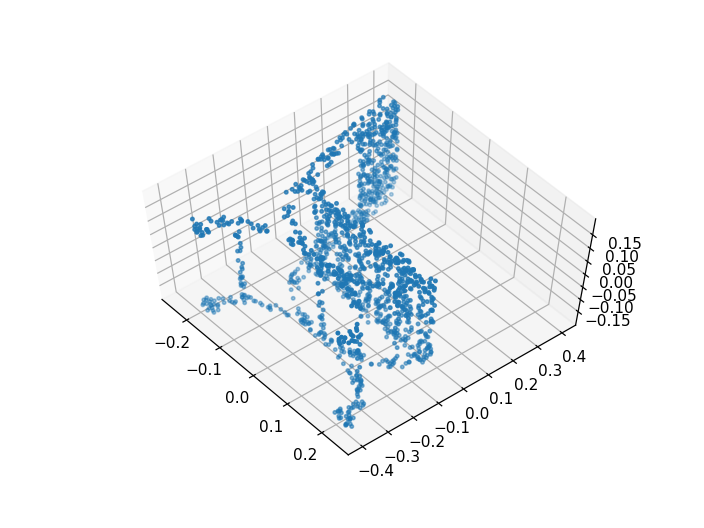

In [31]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = pointcloud[:,0]
y = pointcloud[:,1]
z = pointcloud[:,2]
ax.scatter(x,y,z, marker = '.')